In [1]:
#%pip install scikit-uplift econml

## Another package to consider is mr_uplift
## That package has some nice features if you need to predict uplift along multiple metrics 
## for example you want to predict clicks, revenue, conversions, and costs

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklift.datasets import fetch_criteo
from sklift.models import SoloModel, TwoModels
from sklift.metrics import uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
from sklift.viz import plot_qini_curve, plot_uplift_preds, plot_uplift_by_percentile, plot_uplift_curve

from econml.metalearners import SLearner, TLearner, XLearner
from sklearn.linear_model import LogisticRegression, LinearRegression
from xgboost import XGBClassifier, XGBRegressor


In [3]:
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [4]:
# You can make the data 10x larger by setting percent10=False
# I am avoiding that here since I don't want everything to be super slow to run
data = fetch_criteo(target_col='all', treatment_col='all', percent10=True)

In [5]:
df = pd.concat([data['target'], data['treatment'], data['data']], axis=1)
df['treatment'] = df['treatment'].astype('int32')
df['exposure'] = df['exposure'].astype('int32')
df['visit'] = df['visit'].astype('int32')
df['conversion'] = df['conversion'].astype('int32')
df

,visit,conversion,exposure,treatment,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11
0,0,0,0,1,26.290533,10.059654,8.214383,4.679882,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,5.300375,-0.168679
1,0,0,0,0,12.616365,10.059654,8.339021,4.679882,10.280525,4.115453,0.294443,4.833815,3.869313,32.101873,5.300375,-0.168679
2,0,0,0,1,17.293231,10.059654,8.214383,2.293959,10.280525,4.115453,-4.595460,4.833815,3.971858,13.190056,5.300375,-0.168679
3,0,0,0,0,12.616365,10.059654,8.788121,4.679882,10.280525,4.115453,0.294443,4.833815,3.943716,13.190056,5.300375,-0.168679
4,0,0,0,1,20.363292,10.059654,8.563419,2.934780,10.280525,4.115453,-12.570178,4.833815,3.863287,18.380112,5.300375,-0.168679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1397955,0,0,0,1,19.003610,10.059654,8.214383,2.293959,10.280525,4.115453,-4.595460,4.833815,3.971858,13.190056,5.300375,-0.168679
1397956,0,0,0,1,23.666942,10.059654,8.214383,4.679882,10.280525,4.115453,-8.281971,4.833815,3.971858,13.190056,5.300375,-0.168679
1397957,0,0,0,0,24.364688,10.059654,8.214383,4.679882,10.280525,4.115453,-6.699321,4.833815,3.971858,13.190056,5.300375,-0.168679
1397958,0,0,0,0,19.475085,10.059654,8.224988,0.719526,13.059169,3.013064,-12.915828,9.224334,3.768021,41.609419,5.323182,-0.267350


## Plot conditional probabilities of the key events of interest

In [6]:
print(pd.DataFrame(df.agg({'treatment':'mean', 'exposure':'mean', 'visit':'mean', 'conversion':'mean'})).T)
print()
print(df.groupby('treatment')[['exposure', 'visit', 'conversion']].mean())
print()
print(df.groupby('exposure')[['visit', 'conversion']].mean())
print()
print(df.groupby('visit')[['conversion']].mean())

   treatment  exposure     visit  conversion
0   0.850001  0.030631  0.046992    0.002916

           exposure     visit  conversion
treatment                                
0          0.000000  0.038199    0.001936
1          0.036037  0.048544    0.003089

             visit  conversion
exposure                      
0         0.035378    0.001309
1         0.414540    0.053782

       conversion
visit            
0        0.000000
1        0.062061


## Since treatment is randomly assigned we can get causal estimates without any controls

In [7]:
print("Effect of treatment on visits")
print(smf.ols('visit ~ treatment', data=df).fit().summary().tables[1])
print("Effect of treatment on conversions")
print(smf.ols('conversion ~ treatment', data=df).fit().summary().tables[1])

Effect of treatment on visits
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0382      0.000     82.670      0.000       0.037       0.039
treatment      0.0103      0.001     20.642      0.000       0.009       0.011
Effect of treatment on conversions
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0019      0.000     16.442      0.000       0.002       0.002
treatment      0.0012      0.000      9.029      0.000       0.001       0.001


## Exposure is *not* randomly assigned, so we will not get valid causal estimates from this comparison

In [8]:
print("Effect of exposure on visits")
print(smf.ols('visit ~ exposure', data=df).fit().summary().tables[1])
print("Effect of exposure on conversions")
print(smf.ols('conversion ~ exposure', data=df).fit().summary().tables[1])

Effect of exposure on visits
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0354      0.000    204.605      0.000       0.035       0.036
exposure       0.3792      0.001    383.786      0.000       0.377       0.381
Effect of exposure on conversions
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0013   4.57e-05     28.666      0.000       0.001       0.001
exposure       0.0525      0.000    201.100      0.000       0.052       0.053


# Heterogeneous Treatment Effects and Uplift

In [9]:
T = 'treatment'
Y = 'visit'
X = data['feature_names']

In [10]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=0)

## Sklift Models

In [11]:
slearner = SoloModel(XGBClassifier())
slearner.fit(X=df_train[X], y=df_train[Y], treatment=df_train[T])

SoloModel(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                  callbacks=None, colsample_bylevel=1,
                                  colsample_bynode=1, colsample_bytree=1,
                                  early_stopping_rounds=None,
                                  enable_categorical=False, eval_metric=None,
                                  feature_types=None, gamma=0, gpu_id=-1,
                                  grow_policy='depthwise', importance_type=None,
                                  interaction_constraints='',
                                  learning_rate=0.300000012, max_bin=256,
                                  max_cat_threshold=64, max_cat_to_onehot=4,
                                  max_delta_step=0, max_depth=6, max_leaves=0,
                                  min_child_weight=1, missing=nan,
                                  monotone_constraints='()', n_estimators=100,
                                  n_jobs=0, num_parallel_tree=1,
                                  predictor='auto', random_state=0, ...))

In [12]:
tlearner = TwoModels(XGBClassifier(), XGBClassifier())
tlearner.fit(X=df_train[X], y=df_train[Y], treatment=df_train[T])

TwoModels(estimator_ctrl=XGBClassifier(base_score=0.5, booster='gbtree',
                                       callbacks=None, colsample_bylevel=1,
                                       colsample_bynode=1, colsample_bytree=1,
                                       early_stopping_rounds=None,
                                       enable_categorical=False,
                                       eval_metric=None, feature_types=None,
                                       gamma=0, gpu_id=-1,
                                       grow_policy='depthwise',
                                       importance_type=None,
                                       interaction_constraints='',
                                       learning_rate=0.300000012, ma...
                                        gamma=0, gpu_id=-1,
                                        grow_policy='depthwise',
                                        importance_type=None,
                                        interaction_constraints='',
                                        learning_rate=0.300000012, max_bin=256,
                                        max_cat_threshold=64,
                                        max_cat_to_onehot=4, max_delta_step=0,
                                        max_depth=6, max_leaves=0,
                                        min_child_weight=1, missing=nan,
                                        monotone_constraints='()',
                                        n_estimators=100, n_jobs=0,
                                        num_parallel_tree=1, predictor='auto',
                                        random_state=0, ...))

In [13]:
# Generate predicted uplift for each observation in the test set
slearner_test_preds = slearner.predict(df_test[X])
tlearner_test_preds = tlearner.predict(df_test[X])

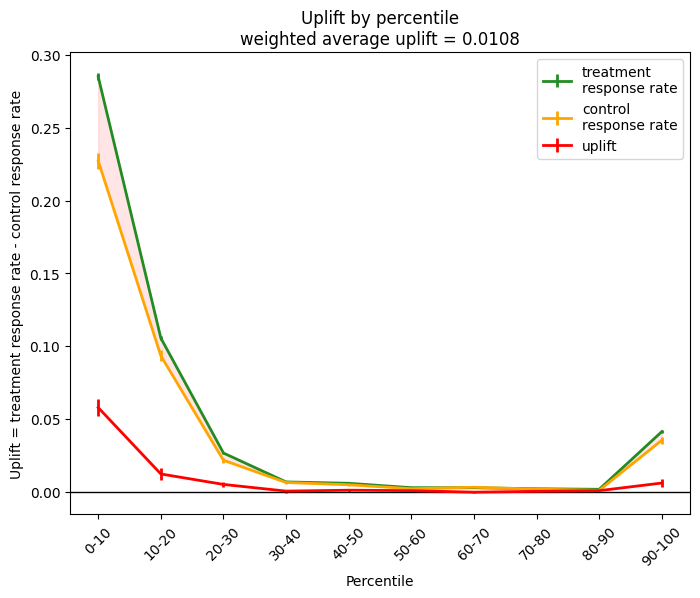

In [14]:
plot_uplift_by_percentile(df_test[Y], slearner_test_preds, df_test[T]);

## EconML Models

In [15]:
# Models from econml
slearner_econml = SLearner(overall_model = XGBRegressor())
slearner_econml.fit(Y=df_train[Y], T=df_train[T], X=df_train[X])

In [16]:
tlearner_econml = TLearner(models = XGBRegressor())
tlearner_econml.fit(Y=df_train[Y], T=df_train[T], X=df_train[X])

In [17]:
xlearner_econml = XLearner(
    models = XGBRegressor(), 
    cate_models=XGBRegressor(),
    propensity_model=XGBClassifier())
xlearner_econml.fit(Y=df_train[Y], T=df_train[T], X=df_train[X])

In [18]:
# Econml uses a different function to estimate the treatment effects
slearner_econml_test_preds = slearner_econml.effect(df_test[X])
tlearner_econml_test_preds = tlearner_econml.effect(df_test[X])
xlearner_econml_test_preds = xlearner_econml.effect(df_test[X])

## Direct Prediction Models

In [19]:
outcome_predictor = XGBClassifier()
outcome_predictor.fit(df_train[X], df_train[Y])
outcome_predictor_test_preds = outcome_predictor.predict_proba(df_test[X])[:, 1]

# Model Comparison

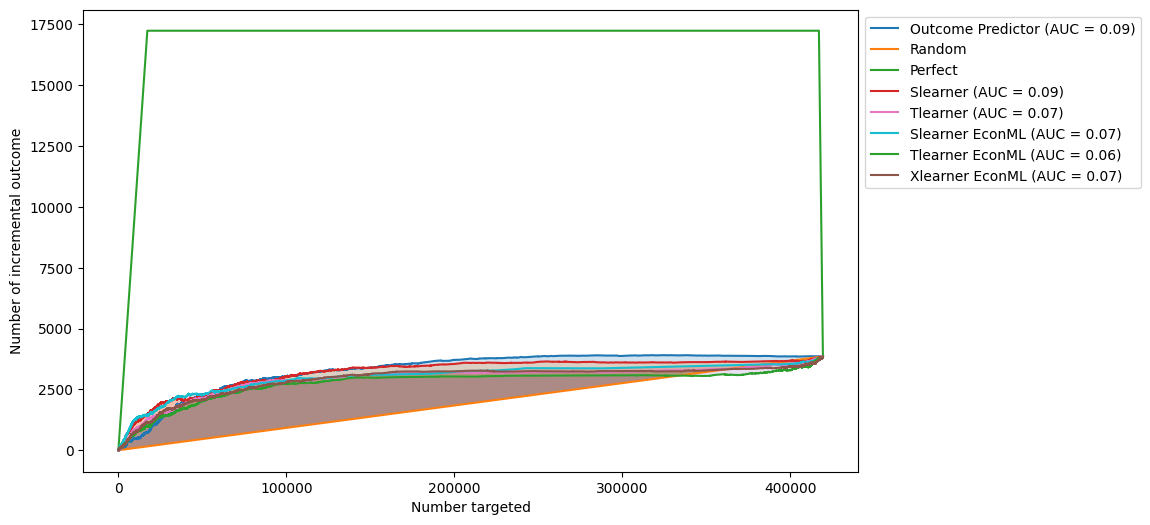

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_qini_curve(df_test[Y], outcome_predictor_test_preds, df_test[T], name='Outcome Predictor', ax=ax)
plot_qini_curve(df_test[Y], slearner_test_preds, df_test[T], name='Slearner', ax=ax)
plot_qini_curve(df_test[Y], tlearner_test_preds, df_test[T], name='Tlearner', ax=ax)
plot_qini_curve(df_test[Y], slearner_econml_test_preds, df_test[T], name='Slearner EconML', ax=ax)
plot_qini_curve(df_test[Y], tlearner_econml_test_preds, df_test[T], name='Tlearner EconML', ax=ax)
plot_qini_curve(df_test[Y], xlearner_econml_test_preds, df_test[T], name='Xlearner EconML', ax=ax)
ax.set_ylim(0, 3000)

In [21]:
def eval_model(data, uplift, name, sample_name):
    return {
        'model': name,
        'sample': sample_name,
        'uplift@10%': uplift_at_k(data[Y], uplift, data[T], strategy="overall", k=0.10),
        'uplift@25%': uplift_at_k(data[Y], uplift, data[T], strategy="overall", k=0.25),
        'uplift@50%': uplift_at_k(data[Y], uplift, data[T], strategy="overall", k=0.50),
        'uplift_auc_score': uplift_auc_score(data[Y], uplift, data[T]),
        'qini_auc_score': qini_auc_score(data[Y], uplift, data[T]),
        'weighted_average_uplift': weighted_average_uplift(data[Y], uplift, data[T]),
    }

In [22]:
pd.DataFrame([
    eval_model(df_test, outcome_predictor_test_preds, 'outcome predictor', 'test'),
    eval_model(df_test, slearner_test_preds, 's-learner', 'test'),
    eval_model(df_test, tlearner_test_preds, 't-learner', 'test'),
    eval_model(df_test, slearner_econml_test_preds, 's-learner econml', 'test'),
    eval_model(df_test, tlearner_econml_test_preds, 't-learner econml', 'test'),
    eval_model(df_test, xlearner_econml_test_preds, 'x-learner econml', 'test'),
])

,model,sample,uplift@10%,uplift@25%,uplift@50%,uplift_auc_score,qini_auc_score,weighted_average_uplift
0,outcome predictor,test,0.055651,0.034255,0.021179,0.035885,0.092130,0.008507
1,s-learner,test,0.057787,0.034358,0.020148,0.033394,0.086060,0.008450
2,t-learner,test,0.054184,0.031893,0.017856,0.026156,0.067479,0.009129
3,s-learner econml,test,0.063929,0.032594,0.018285,0.028595,0.073842,0.008840
4,t-learner econml,test,0.049324,0.030645,0.017022,0.021880,0.056290,0.008848
5,x-learner econml,test,0.054046,0.031765,0.018371,0.025802,0.066482,0.009013


# Repeat process with conversion as the outcome of interest

In [23]:
T = 'treatment'
Y = 'conversion'
X = data['feature_names']

slearner = SoloModel(XGBClassifier())
slearner.fit(X=df_train[X], y=df_train[Y], treatment=df_train[T])
slearner_test_preds = slearner.predict(df_test[X])

tlearner = TwoModels(XGBClassifier(), XGBClassifier())
tlearner.fit(X=df_train[X], y=df_train[Y], treatment=df_train[T])
tlearner_test_preds = tlearner.predict(df_test[X])

# Models from econml
slearner_econml = SLearner(overall_model = XGBRegressor())
slearner_econml.fit(Y=df_train[Y], T=df_train[T], X=df_train[X])
slearner_econml_test_preds = slearner_econml.effect(df_test[X])

tlearner_econml = TLearner(models = XGBRegressor())
tlearner_econml.fit(Y=df_train[Y], T=df_train[T], X=df_train[X])
tlearner_econml_test_preds = tlearner_econml.effect(df_test[X])

xlearner_econml = XLearner(
    models = XGBRegressor(), 
    cate_models=XGBRegressor(),
    propensity_model=XGBClassifier())
xlearner_econml.fit(Y=df_train[Y], T=df_train[T], X=df_train[X])
xlearner_econml_test_preds = xlearner_econml.effect(df_test[X])

# Direct Prediction Models
outcome_predictor = XGBClassifier()
outcome_predictor.fit(df_train[X], df_train[Y])
outcome_predictor_test_preds = outcome_predictor.predict_proba(df_test[X])[:, 1]

In [ ]:
## With conversion as our outcome, we can also make a prediction model that predicts visit
## and then use that as a proxy variable for conversion. The idea here is that visits are much more common
## than conversions, so they are easier to predict. We then assume that users who visit the site are more likely
## to convert than users who don't visit the site. 
proxy_predictor = XGBClassifier()
proxy_predictor.fit(df_train[X], df_train['visit'])
proxy_predictor_test_preds = proxy_predictor.predict_proba(df_test[X])[:, 1]

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
#plot_qini_curve(df_test[Y], outcome_predictor_test_preds, df_test[T], perfect=True, negative_effect=False, name='Outcome Predictor', ax=ax)
plot_qini_curve(df_test[Y], outcome_predictor_test_preds, df_test[T], name='Outcome Predictor', ax=ax, color='black')
plot_qini_curve(df_test[Y], proxy_predictor_test_preds, df_test[T], name='Proxy Predictor', ax=ax, color='grey', linestyle='dotted')
plot_qini_curve(df_test[Y], slearner_test_preds, df_test[T], name='Slearner', ax=ax)
plot_qini_curve(df_test[Y], tlearner_test_preds, df_test[T], name='Tlearner', ax=ax);
plot_qini_curve(df_test[Y], slearner_econml_test_preds, df_test[T], name='Slearner EconML', ax=ax)
plot_qini_curve(df_test[Y], tlearner_econml_test_preds, df_test[T], name='Tlearner EconML', ax=ax)
plot_qini_curve(df_test[Y], xlearner_econml_test_preds, df_test[T], name='Xlearner EconML', ax=ax)
ax.set_ylim(0, 375)

In [ ]:
pd.DataFrame([
    eval_model(df_test, outcome_predictor_test_preds, 'outcome predictor', 'test'),
    eval_model(df_test, proxy_predictor_test_preds, 'proxy predictor', 'test'),
    eval_model(df_test, slearner_test_preds, 's-learner', 'test'),
    eval_model(df_test, tlearner_test_preds, 't-learner', 'test'),
    eval_model(df_test, slearner_econml_test_preds, 's-learner econml', 'test'),
    eval_model(df_test, tlearner_econml_test_preds, 't-learner econml', 'test'),
    eval_model(df_test, xlearner_econml_test_preds, 'x-learner econml', 'test'),
])